In [14]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm


check_variants=False

df=pd.read_csv('train.csv')
df.sample(30)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1079,1149_01,Earth,False,G/178/S,55 Cancri e,8.0,False,0.0,0.0,0.0,0.0,0.0,Lyne Logannon,True
7330,7843_01,Mars,True,NaN,TRAPPIST-1e,75.0,False,0.0,0.0,0.0,0.0,0.0,Weet Petie,True
4357,4638_01,Europa,False,B/153/P,TRAPPIST-1e,62.0,True,0.0,1633.0,0.0,1742.0,0.0,Salas Asticit,True
7616,8136_01,Europa,True,C/268/P,55 Cancri e,26.0,False,0.0,0.0,0.0,0.0,0.0,Alphact Inderad,True
6910,7326_01,Earth,False,F/1519/P,TRAPPIST-1e,47.0,False,2916.0,0.0,14.0,63.0,0.0,France Barbes,False
6087,6433_01,Mars,False,D/193/S,55 Cancri e,53.0,False,83.0,0.0,1590.0,60.0,0.0,Permit Prité,True
8477,9059_01,Earth,False,F/1753/S,TRAPPIST-1e,16.0,False,866.0,0.0,0.0,184.0,0.0,Anda Gregordy,False
6180,6525_03,Earth,True,G/1061/S,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,Raceky Cardners,True
427,0461_01,Earth,False,E/27/S,PSO J318.5-22,31.0,False,0.0,869.0,0.0,0.0,0.0,Shany Yorkland,True
3205,3449_01,Earth,False,G/556/S,TRAPPIST-1e,29.0,False,0.0,4.0,0.0,0.0,904.0,Virgie Chardsons,False


/var/folders/yl/qjs6b9wn4zx7nh630c4my9lw0000gn/T/ipykernel_85394/1190096208.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

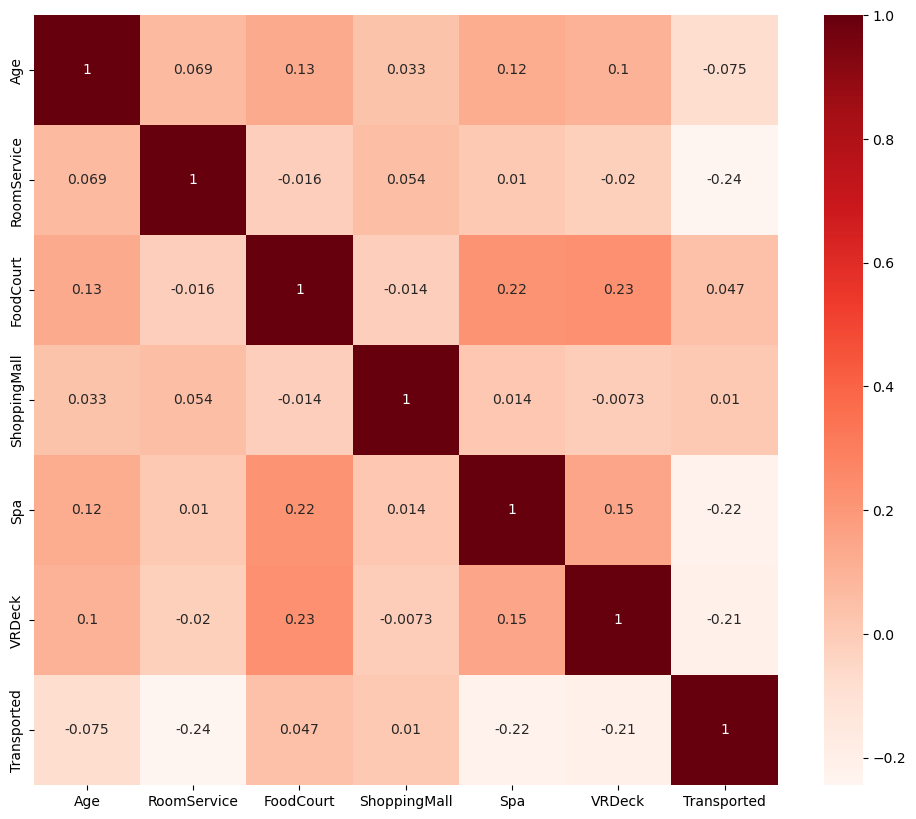

In [15]:
# plot heatmap

import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)

In [16]:
def prepare_dataset(df):
    df_new=df.copy()
    df_new["group"]=df_new["PassengerId"].str[:4]
    
    # group is too uniuqe to be a feature, takle group size into account
    df_new["group_size"]=df_new.groupby("group")["group"].transform("count")
    
    # drop group
    df_new=df_new.drop("group",axis=1)
    
    df_new["deck"]=df_new["Cabin"].str[:1]
    df_new["side"]=df_new["Cabin"].str[-1:]
    
    # drop name, cabin, passenger id
    df_new=df_new.drop(["Name","PassengerId","Cabin"],axis=1)
    
    # convert cat columns into one hot encoding
    from sklearn.preprocessing import OneHotEncoder
    cat_cols=df_new.select_dtypes(include=['object']).columns
    
    encoder=OneHotEncoder()
    encoder.fit(df_new[cat_cols])
    encoded=encoder.transform(df_new[cat_cols]).toarray()
    encoded_df=pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))
    df_new=encoded_df
    
    # glue the non cat columns back
    df_new=pd.concat([df_new,df.select_dtypes(exclude=['object'])],axis=1)
    
    # create new feature XX_is_na for all columns with missing values
    for col in df_new.columns:
        if df_new[col].isna().sum()>0:
            df_new[col+"_is_na"]=df_new[col].isna()
            
    # fill missing values with median
    df_new=df_new.fillna(df_new.median())
    
    df_new["group"]=df["PassengerId"].str[:4]
    
    # group is too uniuqe to be a feature, takle group size into account
    df_new["group_size"]=df_new.groupby("group")["group"].transform("count")
    
    # drop group
    df_new=df_new.drop("group",axis=1)
    
    return df_new

    
df=prepare_dataset(df)
df.head()


,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_nan,CryoSleep_False,CryoSleep_True,CryoSleep_nan,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,...,Spa,VRDeck,Transported,Age_is_na,RoomService_is_na,FoodCourt_is_na,ShoppingMall_is_na,Spa_is_na,VRDeck_is_na,group_size
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,False,False,False,False,False,False,False,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,549.0,44.0,True,False,False,False,False,False,False,1
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,6715.0,49.0,False,False,False,False,False,False,False,2
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3329.0,193.0,False,False,False,False,False,False,False,2
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,565.0,2.0,True,False,False,False,False,False,False,1


In [17]:
df.columns

Index(['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'HomePlanet_nan', 'CryoSleep_False', 'CryoSleep_True', 'CryoSleep_nan',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Destination_nan', 'VIP_False', 'VIP_True',
       'VIP_nan', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F',
       'deck_G', 'deck_T', 'deck_nan', 'side_P', 'side_S', 'side_nan', 'Age',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Age_is_na', 'RoomService_is_na', 'FoodCourt_is_na',
       'ShoppingMall_is_na', 'Spa_is_na', 'VRDeck_is_na', 'group_size'],
      dtype='object')

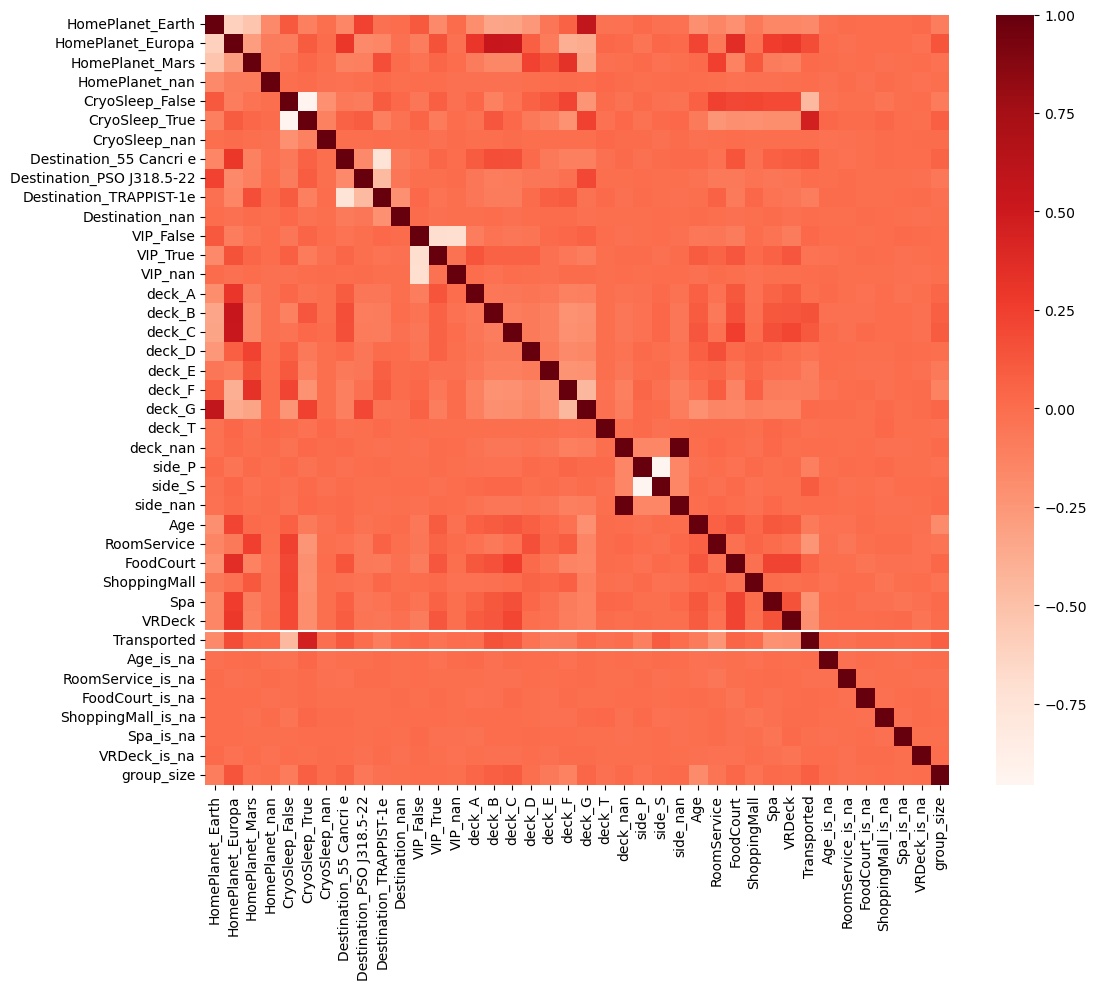

In [18]:
# heatmap
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
# highlight the transported row
plt.axhline(y=32, color='w', linestyle='-')
plt.axhline(y=33, color='w', linestyle='-')

In [19]:
# split
from sklearn.model_selection import train_test_split
X=df.drop("Transported",axis=1)
y=df["Transported"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)


## just simple models

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
    
    
def knn(X_train,y_train,X_test,y_test):
    knn=KNeighborsClassifier()
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    print("Accuracy KNN: ",accuracy_score(y_test,y_pred))
knn(X_train,y_train,X_test,y_test)

Accuracy KNN:  0.757906843013226


In [21]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train,y_train,X_test,y_test):
    dt=DecisionTreeClassifier(max_depth=5)
    dt.fit(X_train,y_train)
    y_pred=dt.predict(X_test)
    print("Accuracy Decision Tree: ",accuracy_score(y_test,y_pred))
    
decision_tree(X_train,y_train,X_test,y_test)

Accuracy Decision Tree:  0.7768832662449684


In [22]:
# random forest

from sklearn.ensemble import RandomForestClassifier

def random_forest(X_train,y_train,X_test,y_test):
    rf=RandomForestClassifier(random_state=42)
    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_test)
    print("Accuracy Random Forest: ",accuracy_score(y_test,y_pred))
    
random_forest(X_train,y_train,X_test,y_test)

Accuracy Random Forest:  0.8016101207590569


In [23]:
# Adaboost

from sklearn.ensemble import AdaBoostClassifier

def adaboost(X_train,y_train,X_test,y_test):
    ada=AdaBoostClassifier(random_state=42)
    ada.fit(X_train,y_train)
    y_pred=ada.predict(X_test)
    print("Accuracy Adaboost: ",accuracy_score(y_test,y_pred))
    
adaboost(X_train,y_train,X_test,y_test)

Accuracy Adaboost:  0.7912593444508338


In [24]:
#svm

from sklearn.svm import SVC

def svm(X_train,y_train,X_test,y_test):
    svm=SVC(random_state=42, C=1, verbose=10)
    svm.fit(X_train,y_train)
    y_pred=svm.predict(X_test)
    print("Accuracy SVM: ",accuracy_score(y_test,y_pred))
    
svm(X_train,y_train,X_test,y_test)


[LibSVM]..
*
optimization finished, #iter = 2803
obj = -3310.501318, rho = -0.483060
nSV = 3528, nBSV = 3381
Total nSV = 3528
Accuracy SVM:  0.7924094307073031


In [25]:
knn(X_train,y_train,X_test,y_test)
decision_tree(X_train,y_train,X_test,y_test)
random_forest(X_train,y_train,X_test,y_test)
adaboost(X_train,y_train,X_test,y_test)
svm(X_train,y_train,X_test,y_test)

Accuracy KNN:  0.757906843013226
Accuracy Decision Tree:  0.7768832662449684
Accuracy Random Forest:  0.8016101207590569
Accuracy Adaboost:  0.7912593444508338
[LibSVM]..
*
optimization finished, #iter = 2803
obj = -3310.501318, rho = -0.483060
nSV = 3528, nBSV = 3381
Total nSV = 3528
Accuracy SVM:  0.7924094307073031


## tune Random Forest

In [26]:
import time

if check_variants:
    rf=RandomForestClassifier(random_state=42)
    time_start=time.time()
    rf.fit(X_train,y_train)
    time_end=time.time()
    print("Time for one fold: ",time_end-time_start, " seconds")

    rf_hyperparameters = {
        'randomforestclassifier__min_samples_leaf': [1, 3, 5],
        'randomforestclassifier__max_depth': [None, 25, 50, 75, 100],
    }
    
    pipeline = make_pipeline(preprocessing.StandardScaler(),
                            RandomForestClassifier(max_features='sqrt',random_state=123))
        
    print(pipeline.get_params())                    
    clf = GridSearchCV(pipeline, rf_hyperparameters, cv=10, verbose=1)
    clf.fit(X_train, y_train)


In [27]:
if check_variants:
    print(clf.best_params_)
    rf_best_params=clf.best_params_
else:
    rf_best_params={'randomforestclassifier__max_depth': None,
 'randomforestclassifier__min_samples_leaf': 3}

In [28]:
def best_rf_pipeline(X_train, y_train):
    rf=RandomForestClassifier(
        random_state=42,
        max_features='sqrt', 
        max_depth=rf_best_params['randomforestclassifier__max_depth'],
        min_samples_leaf=rf_best_params['randomforestclassifier__min_samples_leaf']
                              )
    rf_pipeline = make_pipeline(preprocessing.StandardScaler(),rf)
    rf_pipeline.fit(X_train,y_train)
    return rf_pipeline
rf_pipeline=best_rf_pipeline(X_train,y_train)
y_pred=rf_pipeline.predict(X_test)
print("Accuracy Random Forest: ",accuracy_score(y_test,y_pred))

Accuracy Random Forest:  0.8039102932719954


## Tune Adaboost

In [29]:
# adaboost hyperparameter tuning

if check_variants:
    
    ada=AdaBoostClassifier(random_state=42)
    time_start=time.time()
    ada.fit(X_train,y_train)
    time_end=time.time()
    print("Time for one fold: ",time_end-time_start, " seconds")
    
    ada_hyperparameters = {
        'adaboostclassifier__learning_rate': [0.1, 0.5, 1.0, 2.0],
        'adaboostclassifier__n_estimators': [50, 100, 200, 500],
    }
    
    pipeline = make_pipeline(preprocessing.StandardScaler(),
                            AdaBoostClassifier(random_state=123))
    print(pipeline.get_params())
    clf = GridSearchCV(pipeline, ada_hyperparameters, cv=10, verbose=1)
    clf.fit(X_train, y_train)

In [30]:
if check_variants:
    print(clf.best_params_)
    ada_best_params=clf.best_params_
else:
    ada_best_params={'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__n_estimators': 200}

In [31]:
def best_ada_pipeline(X_train, y_train):
    
    ada=AdaBoostClassifier(random_state=42,
                           learning_rate=ada_best_params['adaboostclassifier__learning_rate'],
                           n_estimators=ada_best_params['adaboostclassifier__n_estimators'])
    ada_pipeline = make_pipeline(preprocessing.StandardScaler(),ada )
    ada_pipeline.fit(X_train,y_train)  
    return ada_pipeline

ada_pipeline=best_ada_pipeline(X_train, y_train)
y_pred=ada_pipeline.predict(X_test)
print("Accuracy Adaboost: ",accuracy_score(y_test,y_pred))


Accuracy Adaboost:  0.7993099482461185


## Tune SVM

In [32]:
# svm hyperparameter tuning

if check_variants:
    
    svm=SVC(random_state=42)
    time_start=time.time()
    ada.fit(X_train,y_train)
    time_end=time.time()
    print("Time for one fold: ",time_end-time_start, " seconds")
    
    svm_hyperparameters = {
        'svc__C': [0.1, 0.5, 1.0, 2.0],
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        
    }
    
    pipeline = make_pipeline(preprocessing.StandardScaler(),
                            SVC(random_state=123))
    print(pipeline.get_params())
    clf = GridSearchCV(pipeline, svm_hyperparameters, cv=10, verbose=3)
    clf.fit(X_train, y_train)

In [33]:
if check_variants:
    print(clf.best_params_)
    svm_best_params=clf.best_params_
else:
    svm_best_params={'svc__C': 2.0, 'svc__kernel': 'linear'}

In [52]:
def best_svm_pipeline(X_train, y_train):
    
    svm=SVC(random_state=42,
                           C=svm_best_params['svc__C'],
                           kernel=svm_best_params['svc__kernel'])
    svm_pipeline = make_pipeline(preprocessing.StandardScaler(),svm )
    svm_pipeline.fit(X_train,y_train)  
    return svm_pipeline

svm_pipeline=best_svm_pipeline(X_train, y_train)
y_pred=svm_pipeline.predict(X_test)
print("Accuracy SVM: ",accuracy_score(y_test,y_pred))


Accuracy SVM:  0.7872340425531915


## combine all

In [53]:
# combine models

from sklearn.ensemble import VotingClassifier

rf_pipeline=best_rf_pipeline(X_train,y_train)
ada_pipeline=best_ada_pipeline(X_train,y_train)
svm_pipeline=best_svm_pipeline(X_train,y_train)

voting=VotingClassifier(estimators=[("rf",rf_pipeline),("ada",ada_pipeline),("svc",svm_pipeline)],voting="hard")
voting.fit(X_train,y_train)
y_pred=voting.predict(X_test)
print("Accuracy Voting: ",accuracy_score(y_test,y_pred))

def get_voting_pipeline(X_train, y_train):
    
    rf_pipeline=best_rf_pipeline(X_train,y_train)
    ada_pipeline=best_ada_pipeline(X_train,y_train)
    svm_pipeline=best_svm_pipeline(X_train,y_train)

    voting=VotingClassifier(estimators=[("rf",rf_pipeline),("ada",ada_pipeline),("svc",svm_pipeline)],voting="hard")
    voting_pipeline = make_pipeline(preprocessing.StandardScaler(),voting )
    voting_pipeline.fit(X_train,y_train)  
    return voting_pipeline

print("Accuracy Voting: ",accuracy_score(y_test,get_voting_pipeline(X_train, y_train).predict(X_test)))


Accuracy Voting:  0.8010350776308223
Accuracy Voting:  0.8010350776308223


## feature importance

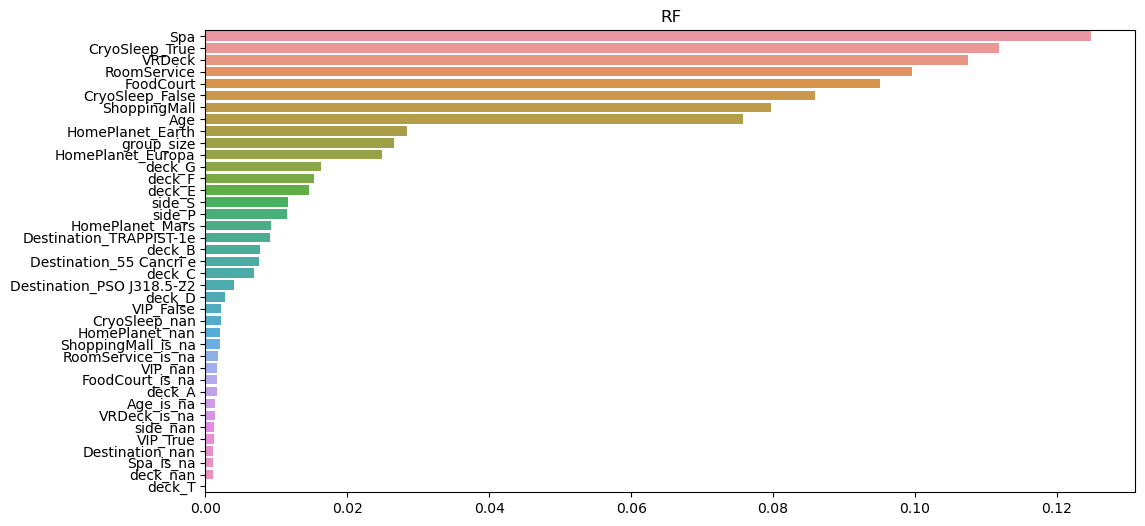

In [36]:
# feature importance

rf_pipeline=best_rf_pipeline(X_train,y_train)
rf=rf_pipeline.named_steps['randomforestclassifier']

importances=rf.feature_importances_

# plot feature importance sorted
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importances,columns, title):
    indices=np.argsort(importances)[::-1]
    plt.figure(figsize=(12,6))
    sns.barplot(x=importances[indices],y=columns[indices])
    plt.title(title)
    plt.show()
    
plot_feature_importance(importances,X_train.columns, "RF")
    

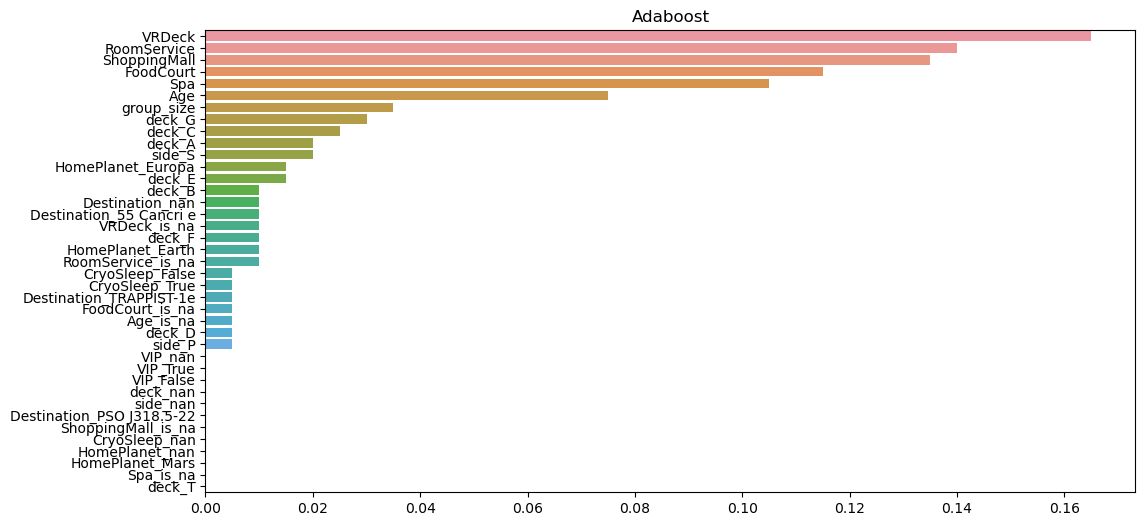

In [37]:
# plot feature importance of adaboost

ada_pipeline=best_ada_pipeline(X_train,y_train)
ada_pipeline=ada_pipeline.named_steps['adaboostclassifier']

importances=ada_pipeline.feature_importances_

plot_feature_importance(importances,X_train.columns, "Adaboost")


# prepare submission

In [38]:
df_test=pd.read_csv("test.csv")
df_test=prepare_dataset(df_test)

df_test.head()

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_nan,CryoSleep_False,CryoSleep_True,CryoSleep_nan,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,...,ShoppingMall,Spa,VRDeck,Age_is_na,RoomService_is_na,FoodCourt_is_na,ShoppingMall_is_na,Spa_is_na,VRDeck_is_na,group_size
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,False,False,False,False,False,False,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2823.0,0.0,False,False,False,False,False,False,1
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,False,False,False,False,False,False,1
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,181.0,585.0,False,False,False,False,False,False,1
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,635.0,0.0,0.0,False,False,False,False,False,False,1


In [39]:
pred_test=voting.predict(df_test)


In [40]:
submission_df=pd.DataFrame({"PassengerId":pd.read_csv("test.csv")["PassengerId"],"Transported":pred_test})
submission_df.to_csv("submission.csv",index=False)

# enhanced feature engineering

In [67]:
def benchmark(process_func=None):
    df=pd.read_csv('train.csv')
    df=prepare_dataset(df)
    
    X=df.drop("Transported",axis=1)
    y=df["Transported"]
    
    if process_func:
        X=process_func(X)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)
    
    voting=get_voting_pipeline(X_train,y_train)
    y_pred=voting.predict(X_test)
    voting_score=accuracy_score(y_test,y_pred)
    
    return {"voting":voting_score}

In [68]:
rf_p=best_rf_pipeline(X_train,y_train)
ada_p=best_ada_pipeline(X_train, y_train)
rf_pipeline=rf_p.named_steps['randomforestclassifier']
ada_pipeline=ada_p.named_steps['adaboostclassifier']
ada_cols=df.columns[np.argsort(rf_pipeline.feature_importances_)][:6]
rf_cols=df.columns[np.argsort(ada_pipeline.feature_importances_)][:6]

cols_to_drop=np.intersect1d(ada_cols,rf_cols)
print("','".join(cols_to_drop))

def remove_lowest_importance_cols(df):
    df_new=df.copy()
    # get lowest 10 feature importance from ada and rf
    
    df_new=df_new.drop(['ShoppingMall_is_na','VIP_True','VIP_nan','deck_T','deck_nan','side_nan'],axis=1)
    return df_new

def remove_fewer_lowest_importance_cols(df):
    df_new=df.copy()
    # get lowest 10 feature importance from ada and rf
    
    df_new=df_new.drop(['deck_T'],axis=1)
    return df_new

Spa_is_na','deck_nan


In [69]:
def sum_expanses(df):
    df_new=df.copy()
    df_new["sum_expanses"]=df_new["FoodCourt"]+df_new["ShoppingMall"]+df_new["Spa"]+df_new["VRDeck"]
    return df_new

def log_expanes(df):
    df_new=df.copy()
    df_new["log_Foodcourt"]=np.log(df_new["FoodCourt"]+1)
    df_new["log_ShoppingMall"]=np.log(df_new["ShoppingMall"]+1)
    df_new["log_Spa"]=np.log(df_new["Spa"]+1)
    df_new["log_VRDeck"]=np.log(df_new["VRDeck"]+1)
    return df_new

def spending_cats(df):
    df_new=df.copy()
    df_new=sum_expanses(df_new)
    median_sum_exp = df_new['sum_expanses'].median()
    bins = [float('-inf'), median_sum_exp / 2, 1.5 * median_sum_exp, float('inf')]
    df_new['SpendingCategory'] = pd.cut(df_new['sum_expanses'], bins=bins,
                                labels=[0, 1, 2], include_lowest=True)
    return df_new
    

In [70]:
def combine_all(df):
    df_new=df.copy()
    df_new=log_expanes(df_new)
    df_new=sum_expanses(df_new)
    df_new=remove_fewer_lowest_importance_cols(df_new)
    spending_cats(df_new)
    return df_new

In [71]:
print("baseline", benchmark())
print("remove lowest importance cols", benchmark(remove_lowest_importance_cols))
print("remove fewer lowest importance cols", benchmark(remove_fewer_lowest_importance_cols))
print("log expanses", benchmark(log_expanes))
print("sum expanses", benchmark(sum_expanses))
print("spending cats", benchmark(spending_cats))
print("combine all", benchmark(combine_all))

baseline {'voting': 0.8010350776308223}
remove lowest importance cols {'voting': 0.7981598619896493}
remove fewer lowest importance cols {'voting': 0.8004600345025877}
log expanses {'voting': 0.8033352501437608}
sum expanses {'voting': 0.7993099482461185}
spending cats {'voting': 0.8010350776308223}
combine all {'voting': 0.8056354226566993}


In [66]:
# create new submission based on combine all

df=pd.read_csv('train.csv')
df=prepare_dataset(df)
df=combine_all(df)

X=df.drop("Transported",axis=1)
y=df["Transported"]

voting=get_voting_pipeline(X,y)

df_test=pd.read_csv("test.csv")
df_test=prepare_dataset(df_test)
df_test=combine_all(df_test)

pred_test=voting.predict(df_test)

submission_df=pd.DataFrame({"PassengerId":pd.read_csv("test.csv")["PassengerId"],"Transported":pred_test})
submission_df.to_csv("submission2.csv",index=False)